# This notebook is to aid in the development of a complete market simulator.

In [1]:
# Basic imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.optimize as spo
import sys
from time import time
from sklearn.metrics import r2_score, median_absolute_error

%matplotlib inline

%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

sys.path.append('../../')

Populating the interactive namespace from numpy and matplotlib


## Let's first create a quantization function

In [2]:
levels = [-13.5, -10.0, -1.0, 2.0, 3.0]

In [3]:
real_value = -6.7
temp_list = levels + [real_value]
temp_list

[-13.5, -10.0, -1.0, 2.0, 3.0, -6.7]

In [4]:
temp_list.sort()
temp_list

[-13.5, -10.0, -6.7, -1.0, 2.0, 3.0]

In [5]:
sorted_index = temp_list.index(real_value)
if sorted_index == 0:
    q_value = levels[0]
elif sorted_index == len(temp_list)-1:
    q_value = levels[-1]
else:
    q_value = (temp_list[sorted_index-1] + temp_list[sorted_index+1])/2
q_value

-5.5

In [6]:
def quantize(real_value, levels):
    temp_list = levels + [real_value]
    temp_list.sort()
    sorted_index = temp_list.index(real_value)
    if sorted_index == 0:
        q_value = levels[0]
    elif sorted_index == len(temp_list)-1:
        q_value = levels[-1]
    else:
        q_value = (temp_list[sorted_index-1] + temp_list[sorted_index+1])/2
    return q_value

In [7]:
levels

[-13.5, -10.0, -1.0, 2.0, 3.0]

In [8]:
x = arange(-20,20,0.2)
x_df = pd.DataFrame(x, columns=['real_value'])
x_df

,real_value
0,-20.0
1,-19.8
2,-19.6
3,-19.4
4,-19.2
5,-19.0
6,-18.8
7,-18.6
8,-18.4
9,-18.2


In [9]:
len(x_df.values.tolist())

200

In [10]:
from functools import partial

# x_df.apply(lambda x:print('{} \n {}'.format(x,'-'*20)), axis=1)
x_df['q_value'] = x_df.apply(lambda x: partial(quantize, levels=levels)(x[0]), axis=1)
x_df.head()

,real_value,q_value
0,-20.0,-13.5
1,-19.8,-13.5
2,-19.6,-13.5
3,-19.4,-13.5
4,-19.2,-13.5


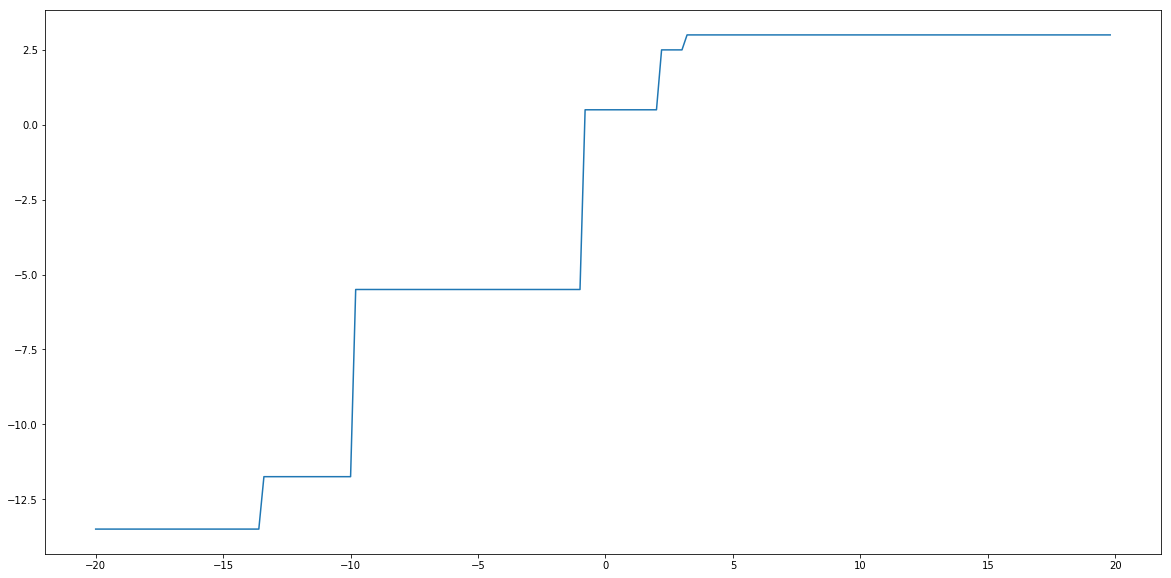

In [11]:
plt.plot(x_df['real_value'], x_df['q_value'])

## Let's create an Indicator and extract some values

In [12]:
data_df = pd.read_pickle('../../data/data_df.pkl')

In [13]:
first_date = data_df.index.get_level_values(0)[0]
first_date

Timestamp('1993-01-29 00:00:00')

In [14]:
one_input_df = data_df.loc[first_date,:]
one_input_df

,SPY,MMM,ABT,ABBV,ACN,ATVI,AYI,ADBE,AMD,AAP,...,XEL,XRX,XLNX,XL,XYL,YHOO,YUM,ZBH,ZION,ZTS
feature,,,,,,,,,,,,,,,,,,,,,
Open,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,0.00,NaN,...,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,0.00,NaN
High,43.97,24.62,6.88,NaN,NaN,NaN,NaN,2.64,19.12,NaN,...,22.00,14.32,2.50,NaN,NaN,NaN,NaN,NaN,10.94,NaN
Low,43.75,24.47,6.75,NaN,NaN,NaN,NaN,2.56,18.62,NaN,...,21.88,13.84,2.46,NaN,NaN,NaN,NaN,NaN,10.62,NaN
Close,43.94,24.50,6.88,NaN,NaN,NaN,NaN,2.59,18.75,NaN,...,22.00,14.28,2.50,NaN,NaN,NaN,NaN,NaN,10.94,NaN
Volume,1003200.00,1242800.00,4638400.00,NaN,NaN,NaN,NaN,4990400.00,730600.00,NaN,...,87800.00,7633602.00,1745196.00,NaN,NaN,NaN,NaN,NaN,33600.00,NaN


Normally, the data to pass to the extractor will be all the data, for one symbol, during a period of some days.

In [15]:
num_days = 50
end_date = data_df.index.get_level_values(0).unique()[num_days-1]

In [16]:
sym_data = data_df['MSFT'].unstack()
sym_data.head()

feature,Close,High,Low,Open,Volume
date,,,,,
1993-01-29,2.70,2.75,2.68,0.0,39424000.0
1993-02-01,2.73,2.75,2.67,0.0,42854400.0
1993-02-02,2.78,2.80,2.73,0.0,70252800.0
1993-02-03,2.76,2.82,2.75,0.0,71728000.0
1993-02-04,2.67,2.74,2.64,0.0,24214400.0


In [17]:
batch_data = sym_data[first_date:end_date]
batch_data.shape

(50, 5)

In [18]:
from recommender.indicator import Indicator

In [19]:
arange(0,1e4,1)

array([  0.00000000e+00,   1.00000000e+00,   2.00000000e+00, ...,
         9.99700000e+03,   9.99800000e+03,   9.99900000e+03])

In [20]:
batch_data.head()

feature,Close,High,Low,Open,Volume
date,,,,,
1993-01-29,2.70,2.75,2.68,0.0,39424000.0
1993-02-01,2.73,2.75,2.67,0.0,42854400.0
1993-02-02,2.78,2.80,2.73,0.0,70252800.0
1993-02-03,2.76,2.82,2.75,0.0,71728000.0
1993-02-04,2.67,2.74,2.64,0.0,24214400.0


In [21]:
ind1 = Indicator(lambda x: x['Close'].mean(), arange(0,10000,100).tolist(), batch_data)

AttributeError: 'float' object has no attribute 'fillna'

In [ ]:
ind1.extracted_data

In [ ]:
ind1.extract(batch_data)

In [ ]:
ind1.q_levels

Another Indicator

In [ ]:
ind2 = Indicator(lambda x: (x['Volume']/x['Close']).max(), arange(0,1e8,1e6).tolist(), batch_data)

In [ ]:
ind2.extract(batch_data)

In [ ]:
(batch_data['Volume']/batch_data['Close']).max()

In [ ]:
ind3 = Indicator(lambda x: x['High'].min(), arange(0,100,1).tolist(), batch_data)

In [ ]:
ind3.extract(batch_data)

## Let's create a function to enumerate states from a vectorial state.

In [ ]:
indicators = [ind1, ind2, ind3]

In [ ]:
vect_state = tuple(map(lambda x: x.extract(batch_data), indicators))
vect_state

Let's generate the q_values for the q_levels

In [ ]:
len(ind1.q_levels)

In [ ]:
q_values = [ind1.q_levels[0]] + ((np.array(ind1.q_levels[1:]) + np.array(ind1.q_levels[:-1])) / 2).tolist() + [ind1.q_levels[-1]]
q_values[:10]

In [ ]:
len(q_values)

### To make it easier to work with states, the "quantize" function was changed. Now it returns the number of interval in which the real value lies, instead of the "approximated, quantized value".

In [ ]:
len(ind1.q_levels)

In [ ]:
import itertools as it

In [ ]:
states_list = list(it.product(np.arange(len(ind1.q_levels)), np.arange(len(ind2.q_levels)), np.arange(len(ind3.q_levels))))

In [ ]:
len(states_list)

In [ ]:
states_list

In [ ]:
states_list.index((5,1,13))

In [ ]:
indicators = {'ind1': ind1,
              'ind2': ind2,
              'ind3': ind3}

In [ ]:
states = list(it.product(*map(lambda x: arange(len(x.q_levels)), indicators.values())))

In [ ]:
states

In [ ]:
len(states)

In [ ]:
states.index((5,1,13))

## Let's now test the bidirectional dictionary to store the states and state vectors.

In [ ]:
states_list = states.copy()

In [ ]:
state_vectors = dict(enumerate(states_list))
state_vectors

In [ ]:
states =  dict(zip(state_vectors.values(), state_vectors.keys()))
states

In [ ]:
import random

In [ ]:
index = random.randint(0, len(states))
index

In [ ]:
states[state_vectors[index]] == index

In [ ]:
state_vectors[states[state_vectors[index]]] == state_vectors[index]

In [ ]:
rand_vec = tuple(np.random.randint(0,100,3))
rand_vec

In [ ]:
state_vectors[states[rand_vec]] == rand_vec

## Let's create a reward function

In [ ]:
from recommender.environment import Environment
from recommender.order import Order

In [ ]:
env = Environment(data_df, indicators)

In [ ]:
env.state_vectors

In [ ]:
len(env.indicators['ind2'].q_levels)

In [ ]:
env.states[(1,100,1)]

In [ ]:
old_pos_df = env.portfolio.get_positions()
reward, new_state = env.get_consequences([Order(['AAPL',Order.BUY, 100]),
                                          Order(['AAPL',Order.SELL, 45]),
                                          Order(['AAPL', Order.BUY, 10])])
new_pos_df = env.portfolio.get_positions()

In [ ]:
old_pos_df

In [ ]:
new_pos_df

In [ ]:
import recommender.portfolio as port

def reward_value_change(old_pos_df, new_pos_df):
    return new_pos_df[port.VALUE].sum() - old_pos_df[port.VALUE].sum()

In [ ]:
def reward_cash_change(old_pos_df, new_pos_df):
    return new_pos_df.loc[port.CASH, port.VALUE] - old_pos_df.loc[port.CASH, port.VALUE]

In [ ]:
reward_value_change(old_pos_df, new_pos_df)

In [ ]:
reward_cash_change(old_pos_df, new_pos_df)

## Let's run a complete Environment-Agent pair.

In [ ]:
data_df.shape

In [ ]:
from recommender.agent import Agent

In [ ]:
NUM_ACTIONS = 3  # BUY, SELL, NOTHING
SYMBOL = 'AAPL'

indicators = {'ind1':}

env = Environment(data_df, indicators=indicators,  symbol=SYMBOL)

agent = Agent(num_states,
              num_actions,
              alpha=0.2,
              gamma=0.9,
              random_actions_rate=0.9,
              random_actions_decrease=0.999,
              dyna_iterations=0,
              verbose=False)

(self,
                 data_df,
                 indicators=None,
                 initial_cap=1000,
                 leverage_limit=3.0,
                 reward_fun=None,
                 symbol='AAPL')
